# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [54]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

C:\Users\cosmi\AppData\Local\Temp\ipykernel_22404\1225062909.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [56]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [57]:
try:
    df_reviews = pd.read_csv('./datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [58]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [59]:
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
4364,tt0214529,movie,Belphegor: Phantom of the Louvre,Belphégor - Le fantôme du Louvre,2001,\N,97,0,"Fantasy,Horror,Mystery",4.5,4583,"OK, I admit that I still associate Sophie Marc...",2,neg,0,test,11098
27849,tt0350258,movie,Ray,Ray,2004,\N,152,0,"Biography,Drama,Music",7.7,135203,Jamie Foxx absolutely IS Ray Charles. His perf...,10,pos,1,test,8481
9702,tt0047976,movie,Dementia,Dementia,1955,\N,56,0,"Film-Noir,Horror,Mystery",6.8,1728,The movie is about a day in the life of a woma...,3,neg,0,test,4051
33142,tt0452718,tvSeries,Surface,Surface,2005,2006,60,0,"Adventure,Drama,Mystery",7.2,9555,"Surface, from the day its teaser first showed ...",9,pos,1,test,12207
4300,tt0120505,movie,Bela Donna,Bela Donna,1998,\N,111,0,"Drama,Romance",4.0,378,"The movie is a happy lullaby, was made to make...",3,neg,0,test,1016
38235,tt0178642,movie,The Invisible Circus,The Invisible Circus,2001,\N,93,0,Drama,5.6,2882,what a waste of time! i expected better from c...,1,neg,0,test,3090
441,tt0154443,movie,8 ½ Women,8 ½ Women,1999,\N,118,0,"Comedy,Drama",5.8,3748,"To overcome the death of his wife, an old man ...",3,neg,0,train,9682
26142,tt0098084,movie,Pet Sematary,Pet Sematary,1989,\N,103,0,"Horror,Thriller",6.6,91372,"Now, I haven't read the original short story t...",4,neg,0,train,3566
10728,tt0116130,movie,Down Periscope,Down Periscope,1996,\N,92,0,Comedy,6.2,20529,The first few minutes of this movie don't do i...,8,pos,1,test,2319
43338,tt0029656,movie,They Gave Him a Gun,They Gave Him a Gun,1937,\N,94,0,"Crime,Drama,Film-Noir",6.4,311,"***SPOILERS*** All too, in real life as well a...",7,pos,1,train,257


In [60]:
# Check for missing values in each column of the DataFrame
missing_values = df_reviews.isnull().sum()

# Print the counts of missing values
print(missing_values)

# # Drop the 'average_rating' and 'votes' columns from the DataFrame
# df_reviews = df_reviews.drop(columns=['average_rating', 'votes'])

# # Display the updated DataFrame to confirm the columns are dropped
# print(df_reviews.info())

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


For the purpose of sentiment analysis focused on classifying movie reviews as positive or negative, the columns **average_rating** and **votes** are not directly relevant. The primary interest lies in the textual content of the reviews (**review** column) and their associated sentiment labels (**pos** column). The **average_rating** and **votes** columns relate more to the overall audience reception of a film, which, while interesting for other types of analysis (e.g., correlating audience reception with sentiment of reviews), do not contribute to the task of sentiment classification based on the review text itself.

In [61]:
# Get simple counts for the 'pos' column (sentiment)
print("Distribution of Sentiments:")
print("Positive = 1; Negative = 0")
print(df_reviews['pos'].value_counts())
print("\n")

# Get simple counts for the 'ds_part' column (dataset partition)
print("Distribution of Dataset Partitions (Train/Test):")
print(df_reviews['ds_part'].value_counts())
print("\n")

# Since 'title_type' and 'genres' can have multiple categories, and 'genres' can be a combination,
# it's useful to explore them for insights but keeping in mind the complexity of 'genres'.
print("Distribution of Title Types:")
print(df_reviews['title_type'].value_counts())
print("\n")

# For 'genres', consider the unique combinations or perhaps the top N if there are many unique combinations.
print("Distribution of Genres (Top 10):")
print(df_reviews['genres'].value_counts().head(10))
print("\n")

# Get simple counts for the 'is_adult' column
print("Distribution of Adult Classification:")
print(df_reviews['is_adult'].value_counts())

Distribution of Sentiments:
Positive = 1; Negative = 0
pos
0    23715
1    23616
Name: count, dtype: int64


Distribution of Dataset Partitions (Train/Test):
ds_part
train    23796
test     23535
Name: count, dtype: int64


Distribution of Title Types:
title_type
movie           36861
tvMovie          2892
video            2742
tvSeries         2246
short             887
tvMiniSeries      713
tvEpisode         635
tvSpecial         183
videoGame         154
tvShort            18
Name: count, dtype: int64


Distribution of Genres (Top 10):
genres
Drama                   3392
Comedy                  2160
Drama,Romance           1808
Horror                  1725
Comedy,Romance          1304
Comedy,Drama,Romance    1212
Comedy,Drama            1181
Action,Crime,Drama       914
Horror,Thriller          890
Crime,Drama              648
Name: count, dtype: int64


Distribution of Adult Classification:
is_adult
0    47249
1       82
Name: count, dtype: int64


Looking at distributions across different dimensions of a dataset is fundamental in understanding its structure, potential biases, and areas that may require special attention during data preprocessing and model training. Here's what we can conclude from the distributions provided:
- The dataset is almost perfectly balanced between positive and negative reviews (23715 negative, 23616 positive). This balance is beneficial for training sentiment analysis models, as it reduces the risk of a model being biased towards predicting one sentiment over the other. No special balancing techniques (e.g., oversampling, undersampling) are necessary based on this distribution.
- The train and test datasets are also nearly balanced (23796 in train, 23535 in test), indicating that the split was done thoughtfully to ensure both datasets are representative of the overall data.
- The majority of reviews are for movies, with significantly fewer reviews for other types like tvMovie, video, and tvSeries. This indicates that any sentiment analysis model trained on this dataset might perform best on movie reviews and potentially less accurately on other media types due to the lower representation in the training data.
- The genre distribution shows a variety of genres with Drama being the most common, followed by Comedy and specific combinations like Drama,Romance and Horror. This diversity is good for building a model that can understand sentiments across different genres. However, the model might be more accurate for genres with more data (like Drama and Comedy) and less accurate for less represented genres.
- The vast majority of reviews are for non-adult content (47249 non-adult vs. 82 adult). This extreme imbalance suggests that any sentiment analysis model developed might not perform well on adult content due to the lack of training data in this category.

In [62]:
df_reviews.duplicated().sum()

0

The dataset has no duplicates meaning each entry is unique, which helps in training a model without the concern of overfitting to repeating entries.

With the dataset checked for missing values, duplicates, and having gained an understanding of its distribution across various dimensions, we are prepared to move on to the next step.

## EDA

Let's check the number of movies and reviews over years.

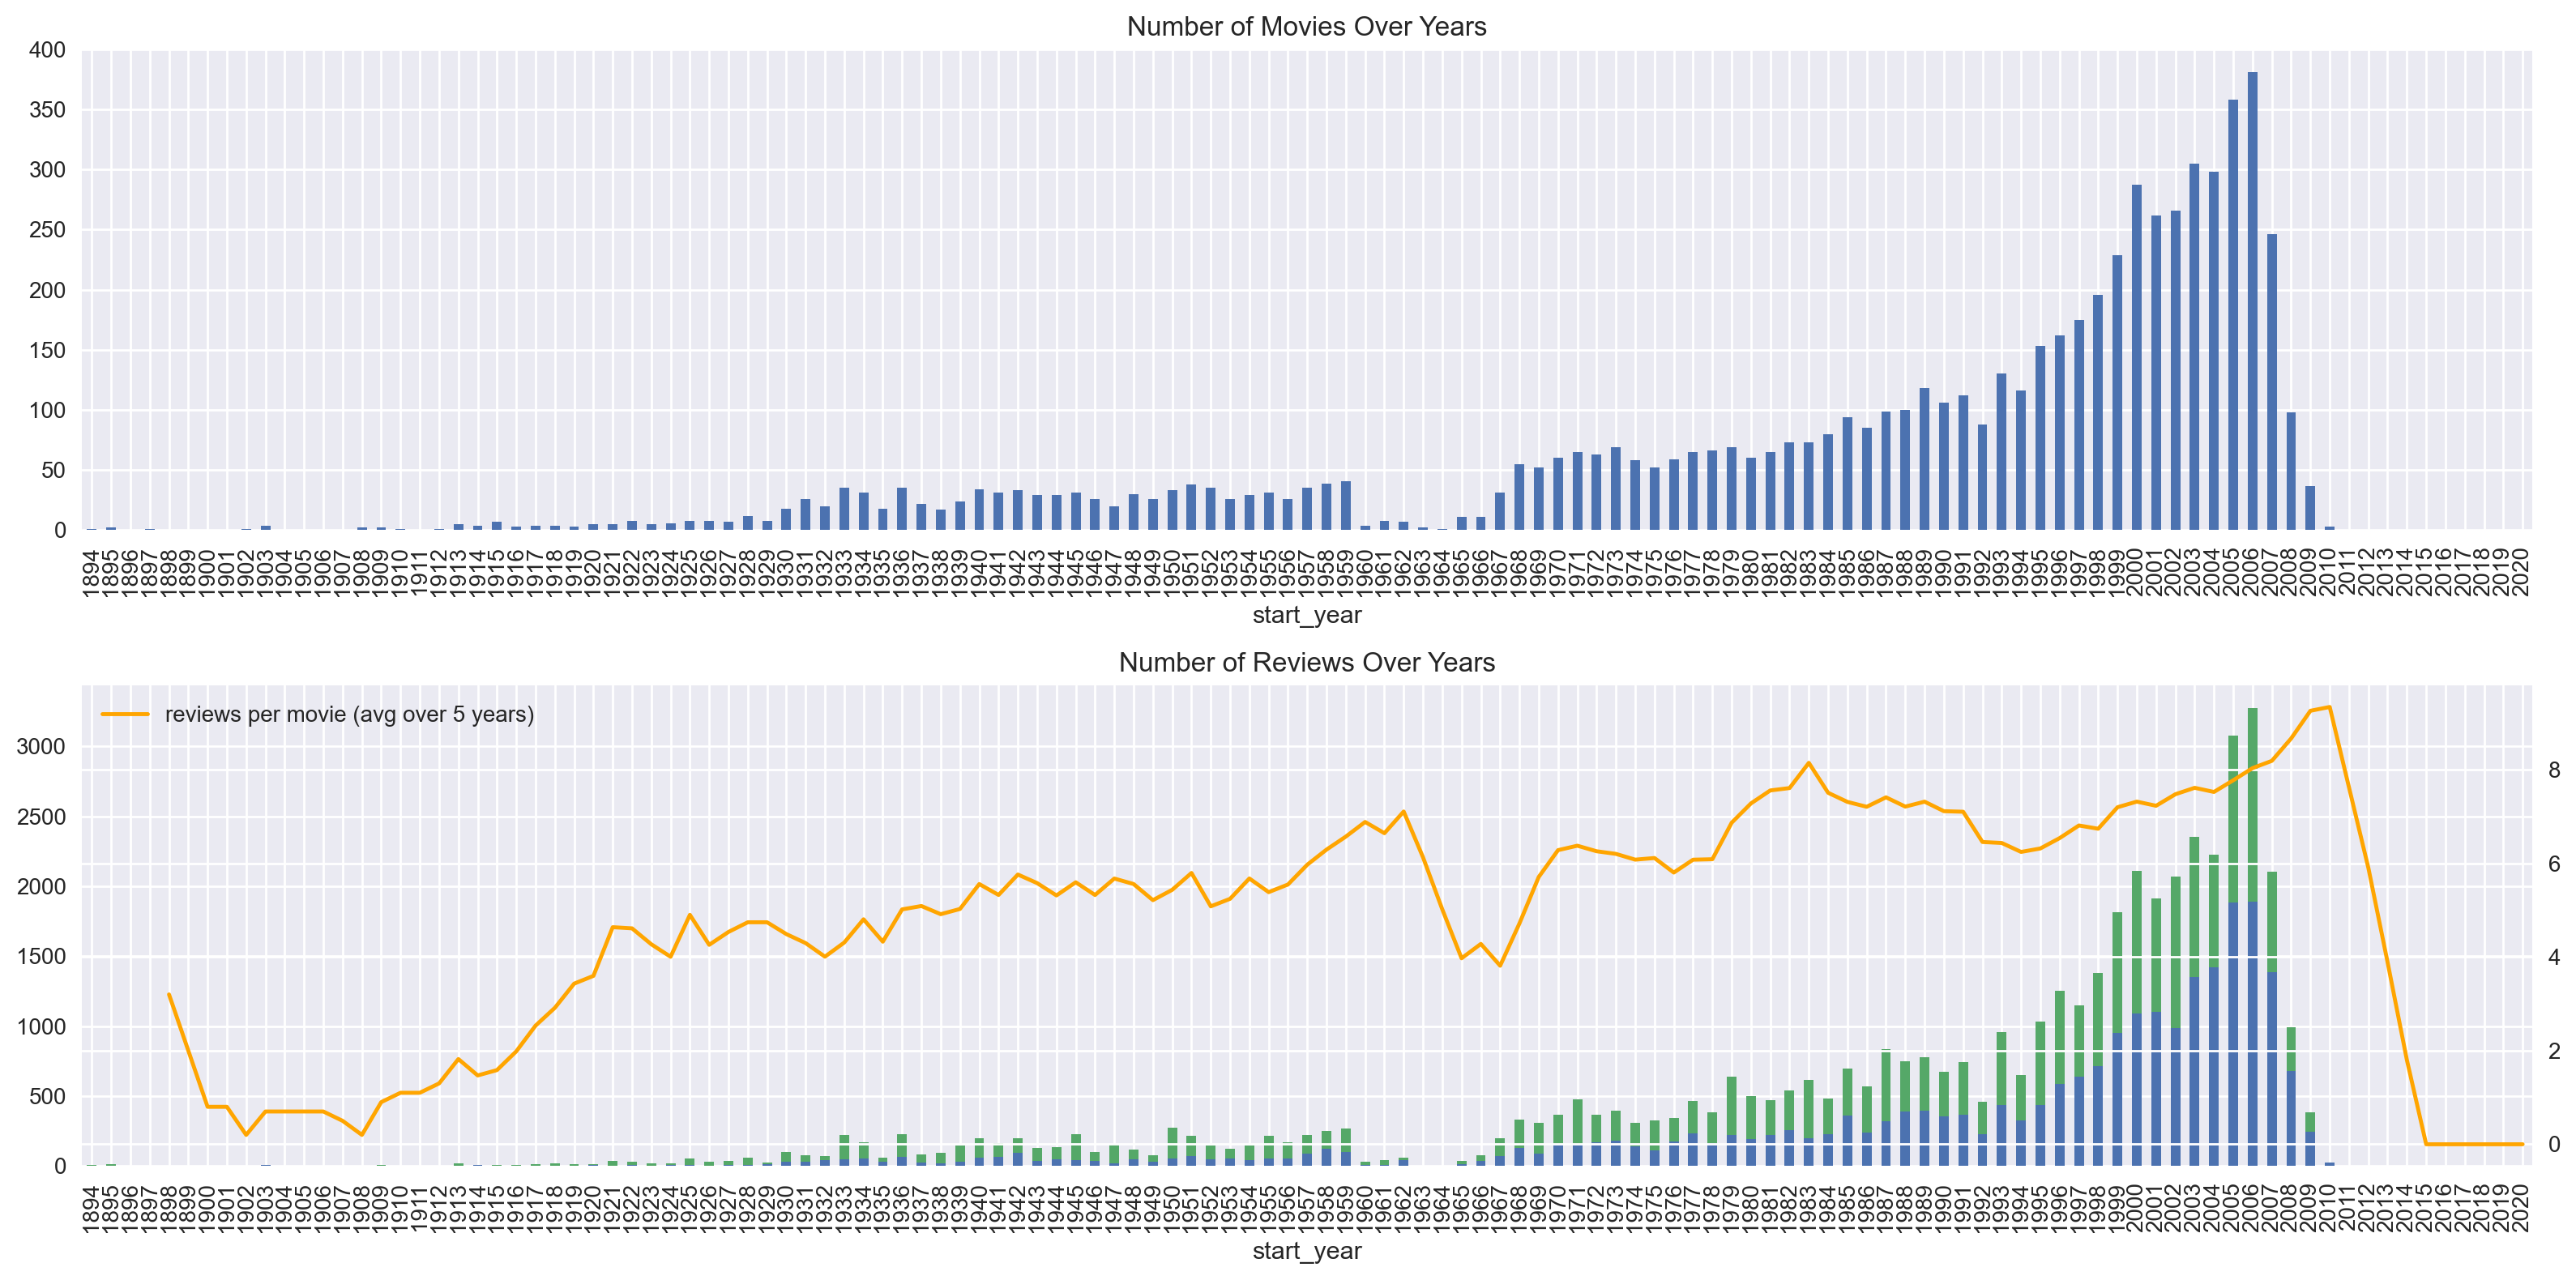

In [63]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

In [66]:
# Find the rolling average of reviews per movie for the years with data
dft3_with_data = dft3.loc[:2010]  # Filter out the years without data
rolling_avg_reviews_per_movie = dft3_with_data.rolling(window=5, min_periods=1).mean()

print("Rolling average of reviews per movie (with data):")
print(rolling_avg_reviews_per_movie.tail())

# Calculate the mean of the rolling average for the available data
mean_rolling_avg_reviews = rolling_avg_reviews_per_movie.mean()

print(f"Mean rolling average of reviews per movie (with data): {mean_rolling_avg_reviews}")

Rolling average of reviews per movie (with data):
start_year
2006    8.034303
2007    8.189355
2008    8.667542
2009    9.258726
2010    9.340291
Name: count, dtype: float64
Mean rolling average of reviews per movie (with data): 5.123874536167498


In [65]:
# Check the unique years present in the original data
unique_years = df_reviews['start_year'].unique()
print("Unique years in the data:")
print(unique_years)

# Check the last non-zero counts for movies
last_non_zero_movie_count = dft1[dft1 > 0].tail(1)
print("Last non-zero movie count:")
print(last_non_zero_movie_count)

# Calculate the mean of non-zero counts for movies and reviews
mean_movies = dft1[dft1 > 0].mean()
mean_reviews = df_reviews['start_year'].value_counts().loc[lambda x: x > 0].mean()

print(f"Mean number of movies (non-zero counts): {mean_movies}")
print(f"Mean number of reviews (non-zero counts): {mean_reviews}")

Unique years in the data:
[1971 2002 1943 2001 1975 1997 1986 1994 2005 2006 2000 2004 1995 1998
 2007 2003 1972 1977 1984 1968 1991 1992 1959 1988 1956 1999 2009 1980
 1983 1915 1908 1990 1996 1903 1987 1985 2008 1948 1941 1989 1937 1982
 1978 1947 1936 1957 1917 1954 1934 1970 1946 1979 1930 1926 1935 1933
 1966 1976 1945 1981 1918 1974 1942 1938 1951 1993 1924 1952 1953 1973
 1912 1949 1969 1940 1950 1958 1960 1955 1939 1929 1967 1932 1961 1965
 1913 1925 1931 1927 1944 2010 1920 1894 1919 1922 1923 1914 1921 1964
 1962 1910 1902 1928 1895 1963 1916 1909 1897]
Last non-zero movie count:
start_year
2010    3.0
Name: count, dtype: float64
Mean number of movies (non-zero counts): 62.13084112149533
Mean number of reviews (non-zero counts): 442.3457943925234


In [67]:
# Adjust the range to the last 10 years ending in 2010
last_10_years = np.arange(2001, 2011)

# 1. Overall trend in the number of movies over the last 10 years ending in 2010
movies_last_10_years = dft1.loc[last_10_years]
movie_count_trend_last_10_years = movies_last_10_years.mean()

# 2. Year with the maximum number of movies in the last 10 years ending in 2010
year_max_movies_last_10_years = movies_last_10_years.idxmax()

# 3. Overall trend in the number of reviews over the last 10 years ending in 2010
reviews_last_10_years = dft2.loc[last_10_years]
review_count_trend_last_10_years = reviews_last_10_years.mean()

# 4. Year with the maximum number of reviews in the last 10 years ending in 2010
year_max_reviews_last_10_years = reviews_last_10_years.idxmax()

# 5. Average number of reviews per movie over the last 5 years ending in 2010
# Adjust the range to the last 5 years ending in 2010
last_5_years = np.arange(2006, 2011)
reviews_per_movie_last_5_years = dft3.loc[last_5_years]
avg_reviews_per_movie_last_5_years = reviews_per_movie_last_5_years.mean()

# Printing the key data points
print(f"Overall trend in the number of movies over the last 10 years ending in 2010: {movie_count_trend_last_10_years}")
print(f"Year with the maximum number of movies in the last 10 years ending in 2010: {year_max_movies_last_10_years}")
print(f"Overall trend in the number of reviews over the last 10 years ending in 2010: {review_count_trend_last_10_years}")
print(f"Year with the maximum number of reviews in the last 10 years ending in 2010: {year_max_reviews_last_10_years}")
print(f"Average number of reviews per movie over the last 5 years ending in 2010: {avg_reviews_per_movie_last_5_years}")

Overall trend in the number of movies over the last 10 years ending in 2010: 225.4
Year with the maximum number of movies in the last 10 years ending in 2010: 2006
Overall trend in the number of reviews over the last 10 years ending in 2010: 1842.7
Year with the maximum number of reviews in the last 10 years ending in 2010: 2006
Average number of reviews per movie over the last 5 years ending in 2010: 9.340290693016419


On average, there were 225.4 movies per year over the last 10 years ending in 2010. The year 2006 had the highest number of movies compared to other years in that decade. Similar to the number of movies, 2006 also had the highest number of reviews. There was an average of 1842.7 reviews per year in the last decade leading up to 2010.  In the last 5 years ending in 2010, there was an average of approximately 9.34 reviews per movie.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

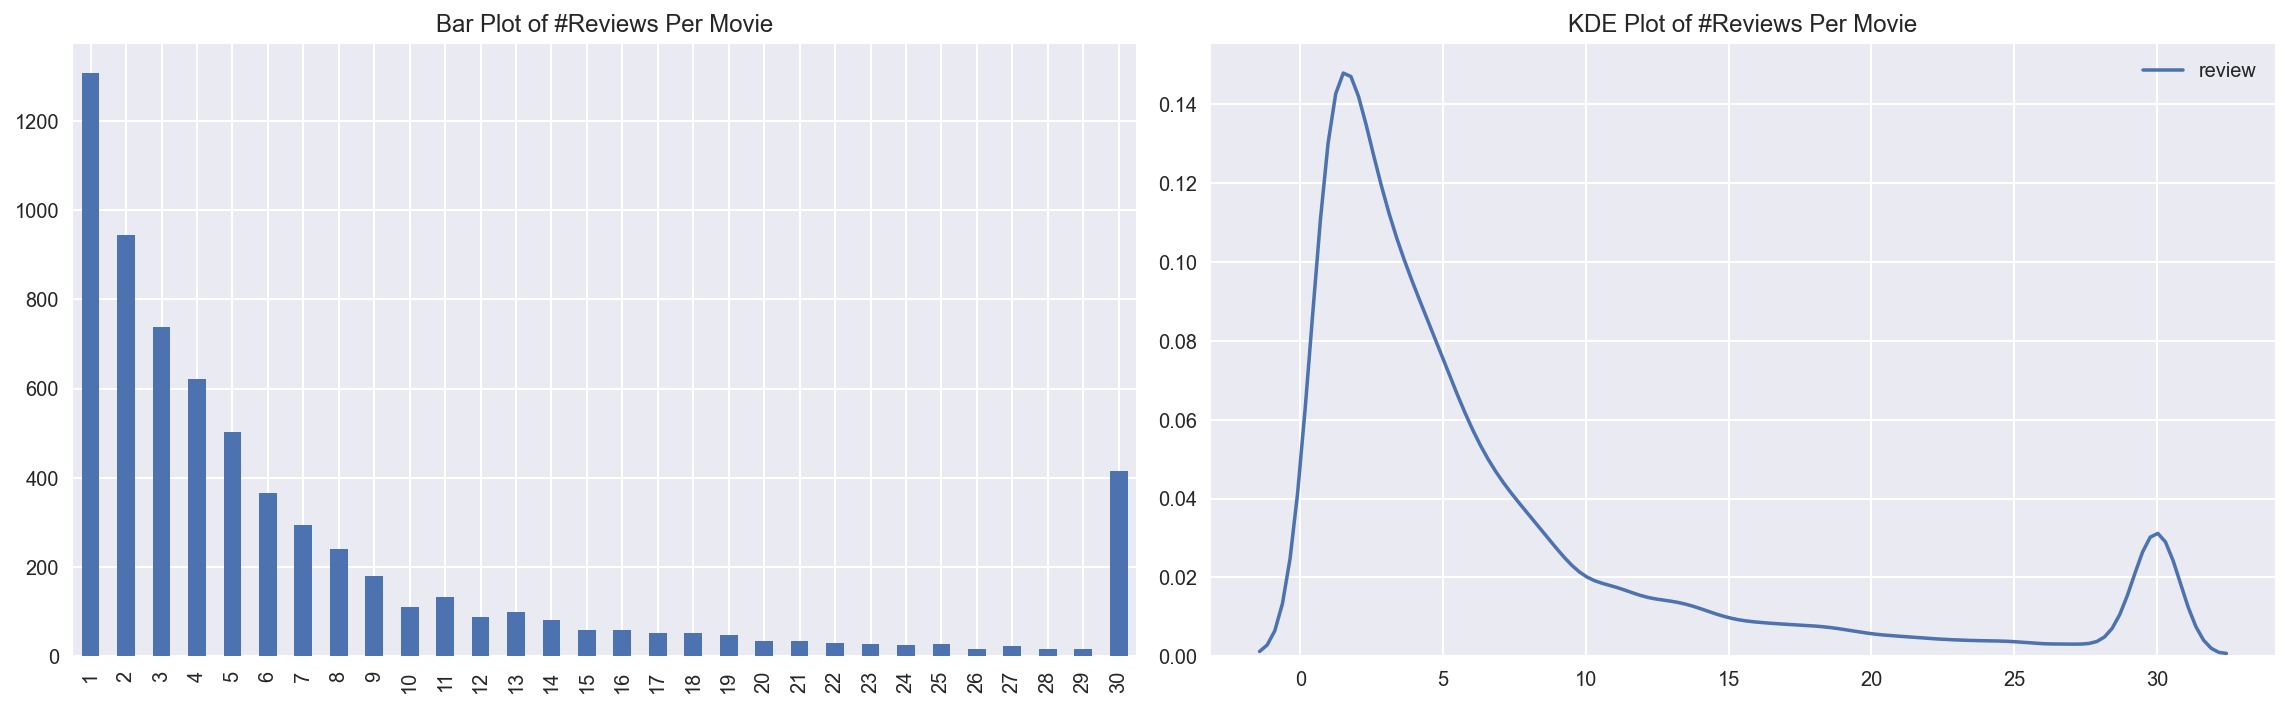

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

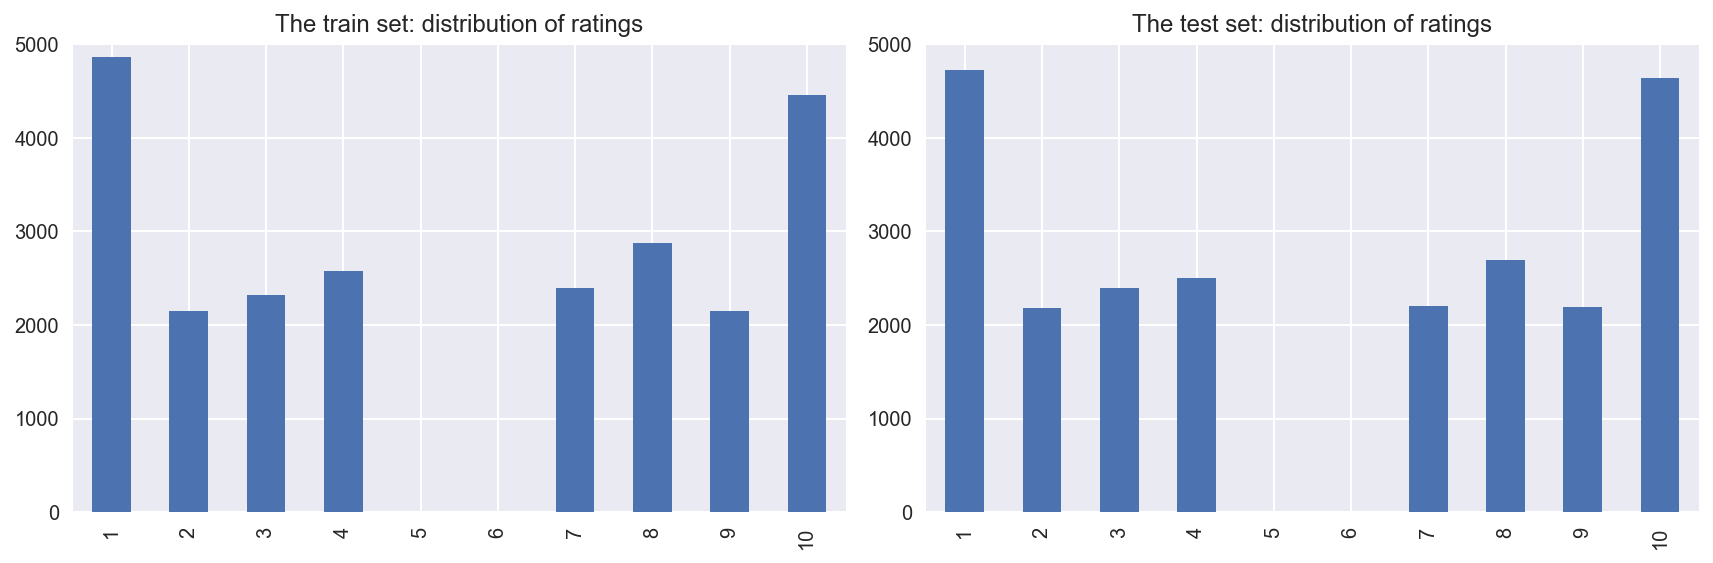

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

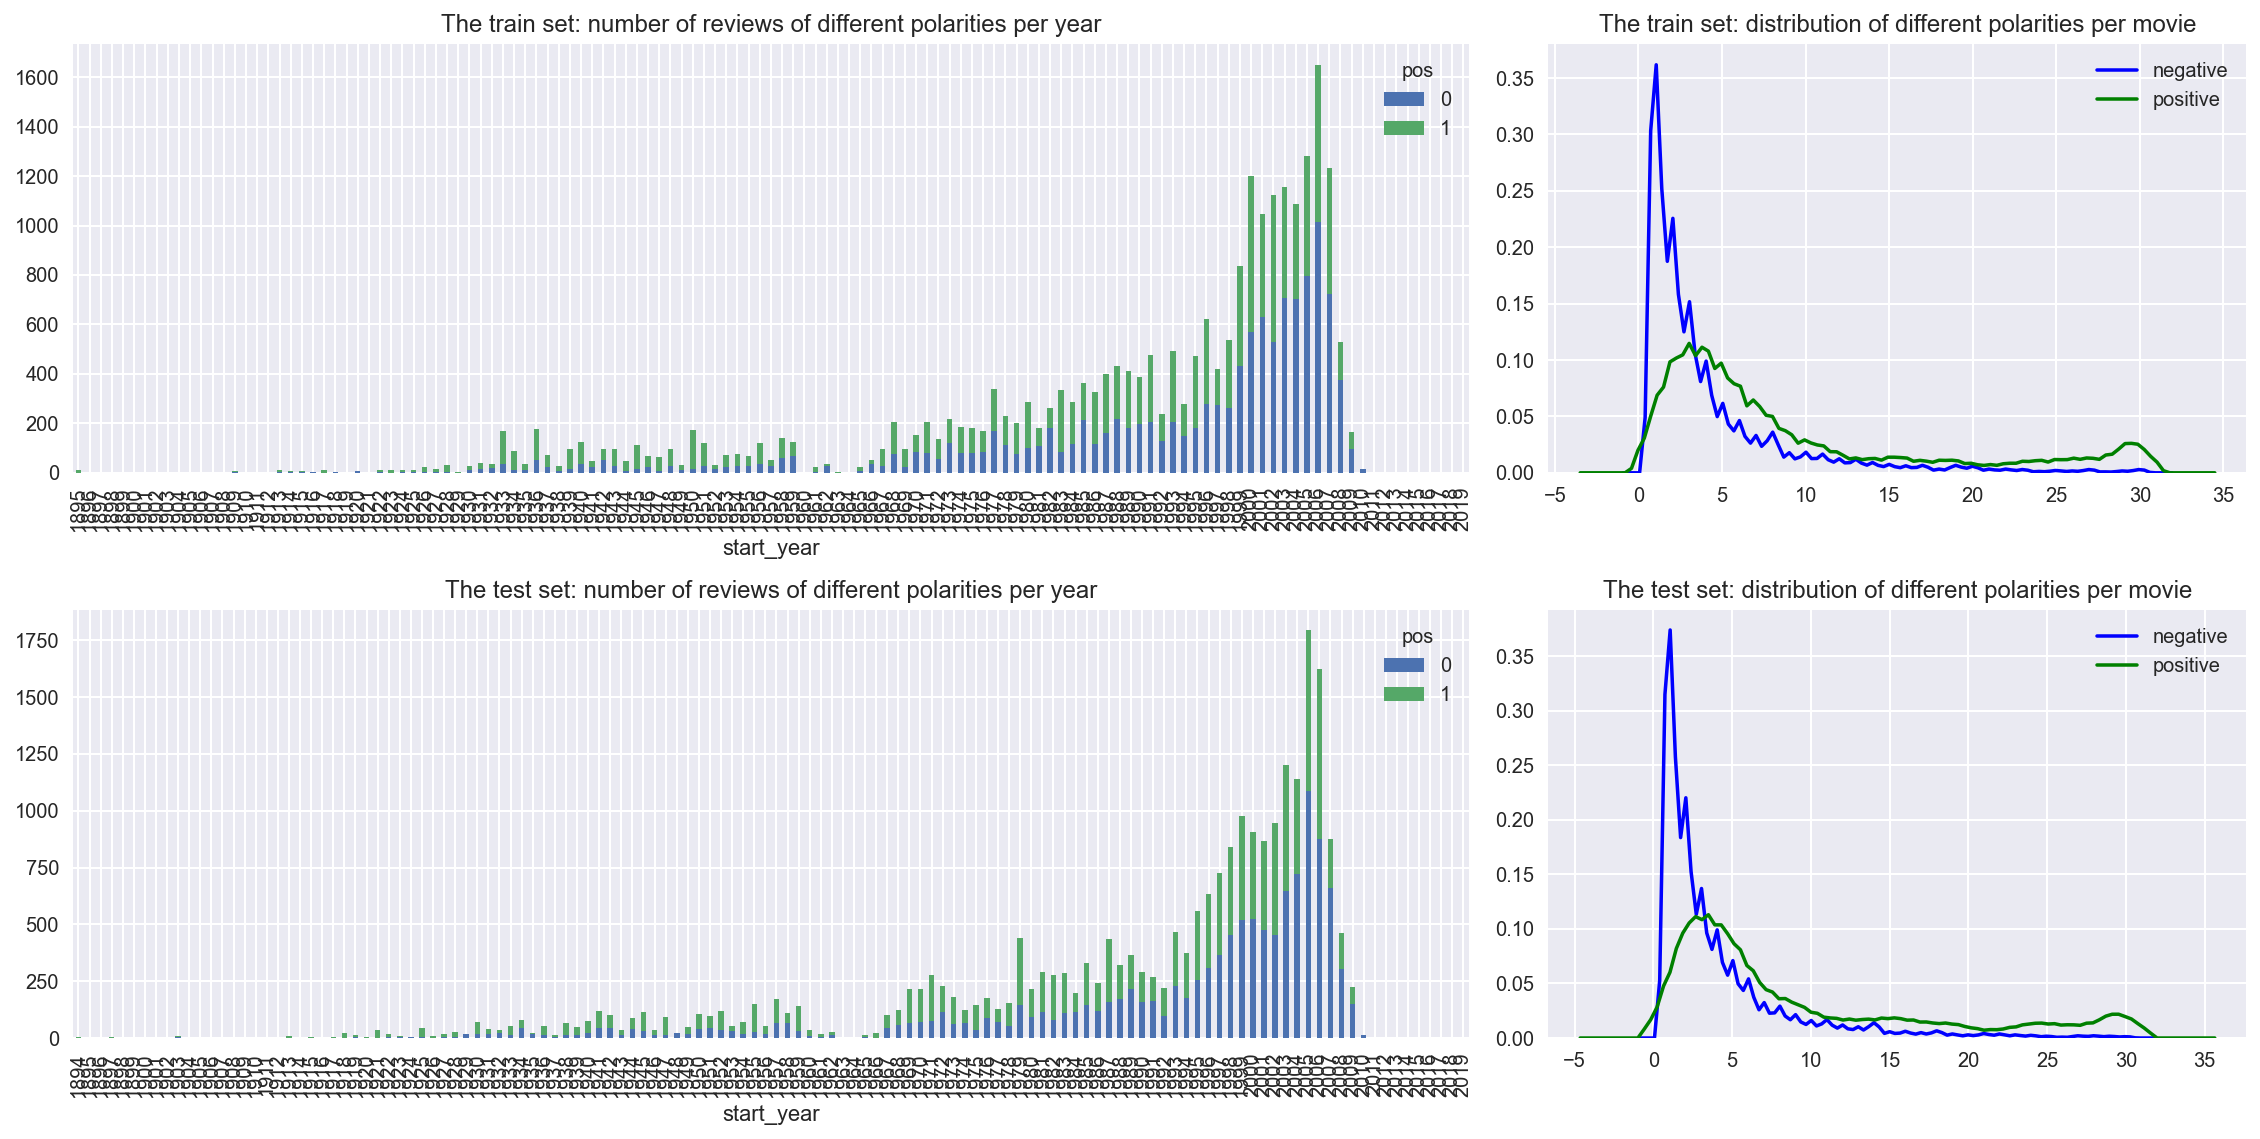

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [ ]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [ ]:
df_reviews['review_norm'] = # <put your code here>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [693]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [ ]:
from sklearn.dummy import DummyClassifier

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [ ]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [ ]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [ ]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = # <put here the same normalization logic as for the main dataset>

my_reviews

### Model 2

In [740]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it  not my kind of movie 
0.16:  well  i was bored and felt asleep in the middle of the movie 
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31:  i didn t expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.82:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 3

In [741]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.40:  i did not simply like it  not my kind of movie 
0.17:  well  i was bored and felt asleep in the middle of the movie 
0.51:  i was really fascinated with the movie
0.31:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31:  i didn t expect the reboot to be so good  writers really cared about the source material
0.54:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.13:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.86:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 4

In [742]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  i did not simply like it  not my kind of movie 
0.32:  well  i was bored and felt asleep in the middle of the movie 
0.59:  i was really fascinated with the movie
0.43:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.58:  i didn t expect the reboot to be so good  writers really cared about the source material
0.63:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.27:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.85:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 9

In [743]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it  not my kind of movie 
0.01:  well  i was bored and felt asleep in the middle of the movie 
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.21:  i didn t expect the reboot to be so good  writers really cared about the source material
0.94:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.09:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.96:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


## Conclusions

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions